_**Note:** This notebook is intended solely as a demonstration of how to use the developed codebase. The outputs and results presented here are for illustrative purposes only and should not be considered accurate, validated, or representative of real-world performance. The focus of this notebook is on showcasing functionality, not on the correctness or significance of the results._

In [19]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../')  # path to root of code_base directory - Only if not installed as a package

from code_base.model_suite.dataloader import generate_dataloader

from code_base.model_suite import training 
from code_base.model_suite.training import get_loss, train_loop
from code_base.model_suite.architectures import get_model
from code_base.model_suite.evaluation_metrics import cal_MeanIoU_score

from code_base.model_suite.utils.inference_utils import load_saved_model, pred_segmentation_mask
from code_base.model_suite.utils.common import load_config
from code_base.model_suite.utils.preprocessing import load_image

In [3]:
torch.cuda.empty_cache()

# Training

In [4]:
config_path = "../configs/segmentation.yaml"
config = load_config(config_path)
pprint(config)

{'data_loader': {'batch_size': 1, 'num_workers': 2, 'shuffle': True},
 'dataset_loc': {'dataset_type': 'segmentation',
                 'train': {'img_dir': '/cs6945share/retro_project/bdd100k/images/train',
                           'mask_dir': '/cs6945share/retro_project/bdd100k/generated_masks_v0_1/train',
                           'random_subset': None},
                 'val': {'img_dir': '/cs6945share/retro_project/bdd100k/images/val',
                         'mask_dir': '/cs6945share/retro_project/bdd100k/generated_masks_v0_1/val',
                         'random_subset': None}},
 'dataset_preprocessing': {'RGB_labelmap': 'configs/kaggle_road_seg.json',
                           'RGB_mask': False,
                           'num_classes': 2,
                           'one_hot_mask': False,
                           'resize_height': 720,
                           'resize_width': 1280},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_channels': 1},
 'results_loc': 

In [12]:
# # copy paste above config here foro quick edit and experimentation
config = {
  'data_loader': {
    'batch_size': 1,
    'num_workers': 2,
    'shuffle': True
  },
  'dataset_loc': {
    'dataset_type': 'segmentation',
    'train': {
      'img_dir': '/cs6945share/retro_project/bdd100k/images/train',
      'mask_dir': '/cs6945share/retro_project/bdd100k/generated_masks_v0_3/masks_v3/train',
      'random_subset': 100   # random subset for demo purpose only - set to None to use entire dataset
    },
    'val': {
      'img_dir': '/cs6945share/retro_project/bdd100k/images/val',
      'mask_dir': '/cs6945share/retro_project/bdd100k/generated_masks_v0_3/masks_v3/val',
      'random_subset': 50    # random subset for demo purpose only - set to None to use entire dataset
    }
  },
  'dataset_preprocessing': {
    'RGB_labelmap': 'configs/kaggle_road_seg.json',
    'RGB_mask': False,
    'num_classes': 2,
    'one_hot_mask': False,
    'resize_height': 720,
    'resize_width': 1280
  },
  'enable_cuda': True,
  'model': {
    'in_channels': 3,
    'out_channels': 1
  },
  'results_loc': '../experiment_results/',
  'training': {
    'learning_rate': 0.001,
    'loss_fn_name': 'BCE',
    'num_epochs': 10,
    'resume_checkpoint': None,
    'save_checkpoint_freq': 5
  }
}

In [13]:
# get required config parameters
model_config = config["model"]
dataset_config = config["dataset_loc"]
dataloader_config = config["data_loader"]
preprocess_config = config.get("dataset_preprocessing", None)
train_config = config["training"]

In [14]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE = training.DEVICE
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [15]:
# update img trasnform if required

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.ToTensor()                    # Convert the image to a tensor
])

# generate train data loader
train_loader, train_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                               data_loc=dataset_config["train"],
                                               dataloader_config=dataloader_config,
                                               preprocess_config=preprocess_config)

# generate validation data loader
val_loader, val_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                           data_loc=dataset_config["val"],
                                           dataloader_config=dataloader_config,
                                           preprocess_config=preprocess_config)

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 100
Validation Dataset loaded. #samples: 50


Image batch shape: torch.Size([1, 3, 720, 1280])
Degradation label shape: torch.Size([1, 1, 720, 1280])


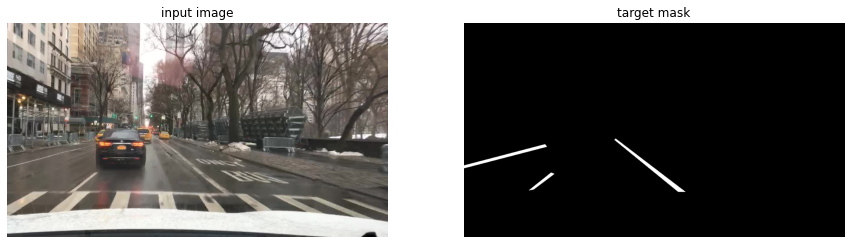

In [21]:
# Ensure that we are getting correct data from data loaders
batch_img, batch_mask = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("Degradation label shape:", batch_mask.shape) 

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

sample_mask = batch_mask[0].numpy()   # (c, h, w)
sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(sample_img)
ax[0].axis("off")
ax[0].set_title("input image")

ax[1].imshow(sample_mask, cmap="gray")
ax[1].axis("off")
ax[1].set_title("target mask")
plt.show()

In [22]:
# Initializing the model, loss function, and the optimizer
model_name = "unet"
model = get_model(model_name, **model_config)
model = model.to(training.DEVICE)

## fetch loss function as set in config
criterion = get_loss(train_config["loss_fn_name"])

## OR add your own loss fucntion like shown below
# from model_suite.focal_loss import FocalLoss
# num_classes = 3
# alpha = [1.0, 1.2, 1.2]  # Example class weights
# criterion = FocalLoss(gamma=2, alpha=alpha, task_type='multi-class', num_classes=num_classes)

# initialized optimizer as required
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))
    print("Model checkpoint loaded.")

In [23]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"], save_prefix=model_name)

Training Started...


Epoch: 1 val - : 100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


Epoch [1/10], Train Loss: 0.1449, Val Loss: 0.3443, Epoch execution time: 0.6 min


Epoch: 2 val - : 100%|██████████| 50/50 [00:05<00:00,  9.63it/s]


Epoch [2/10], Train Loss: 0.0470, Val Loss: 0.0581, Epoch execution time: 0.57 min


Epoch: 3 val - : 100%|██████████| 50/50 [00:05<00:00,  9.31it/s]


Epoch [3/10], Train Loss: 0.0362, Val Loss: 0.0275, Epoch execution time: 0.58 min


Epoch: 4 val - : 100%|██████████| 50/50 [00:05<00:00,  9.50it/s]


Epoch [4/10], Train Loss: 0.0334, Val Loss: 0.0344, Epoch execution time: 0.57 min


Epoch: 5 val - : 100%|██████████| 50/50 [00:05<00:00,  9.23it/s]


Epoch [5/10], Train Loss: 0.0327, Val Loss: 0.0262, Epoch execution time: 0.57 min


Epoch: 6 val - : 100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


Epoch [6/10], Train Loss: 0.0314, Val Loss: 0.0277, Epoch execution time: 0.58 min


Epoch: 7 val - : 100%|██████████| 50/50 [00:05<00:00,  9.14it/s]


Epoch [7/10], Train Loss: 0.0311, Val Loss: 0.0272, Epoch execution time: 0.57 min


Epoch: 8 val - : 100%|██████████| 50/50 [00:05<00:00,  9.67it/s]


Epoch [8/10], Train Loss: 0.0308, Val Loss: 0.0273, Epoch execution time: 0.57 min


Epoch: 9 val - : 100%|██████████| 50/50 [00:05<00:00,  9.30it/s]


Epoch [9/10], Train Loss: 0.0295, Val Loss: 0.0252, Epoch execution time: 0.57 min


Epoch: 10 val - : 100%|██████████| 50/50 [00:05<00:00,  9.57it/s]


Epoch [10/10], Train Loss: 0.0289, Val Loss: 0.0313, Epoch execution time: 0.57 min
   Learning curve saved to ../experiment_results/train_log/learning_curve_2025-04-16_07-40-15.png
   Learning history saved to ../experiment_results/train_log/learning_history_2025-04-16_07-40-15.json
Model saved at: ../experiment_results/checkpoints/unet_final_2025-04-16_07-40-15.pth
Training Completed! Total time: 5.7791 min


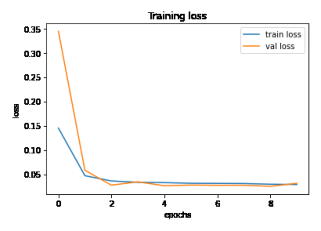

In [24]:
# open saved learning curve
plot_saved_path = "../experiment_results/train_log/learning_curve_2025-04-16_07-40-15.png"    # replace with required path
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [25]:
# Evaluate model performance at end of training using different losses
train_mIoU = cal_MeanIoU_score(model=model, data_loader=train_loader, num_classes=preprocess_config["num_classes"], device=DEVICE)
val_mIoU = cal_MeanIoU_score(model=model, data_loader=val_loader, num_classes=preprocess_config["num_classes"], device=DEVICE)
print("Train mIoU Score:", train_mIoU)
print("Val mIoU Score:", val_mIoU)

100%|██████████| 50/50 [00:04<00:00, 10.83it/s]

Train mIoU Score: [0.9940754 0.       ]
Val mIoU Score: [0.9955656 0.       ]


# Inference

In [26]:
# replace with requried path
saved_weight_path = "../experiment_results/checkpoints/unet_final_2025-04-16_07-40-15.pth"

In [27]:
model_name = "unet"
model_config = {'in_channels': 3, 'out_channels': 1}

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [29]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

In [33]:
img_dir = dataset_config["val"]["img_dir"]
mask_dir = dataset_config["val"]["mask_dir"]

test_img_name = "b1c66a42-6f7d68ca.jpg"
test_img_path = os.path.join(img_dir, test_img_name)
test_img = load_image(test_img_path)

Test image name: b1c66a42-6f7d68ca.jpg
Test image shape: (720, 1280, 3)


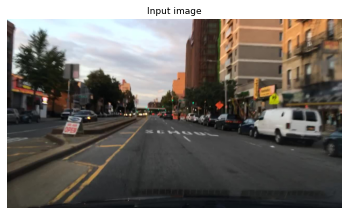

In [34]:
print("Test image name:", test_img_name)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [39]:
pred_mask = pred_segmentation_mask(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
pred_mask = np.squeeze(pred_mask)

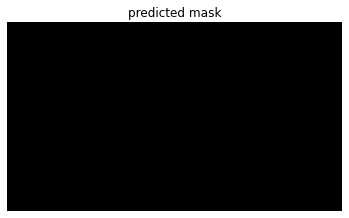

In [43]:
plt.imshow(pred_mask, cmap="gray")
plt.title("predicted mask")
plt.axis("off")
plt.show()